In [ ]:
! pip install pmdarima
#!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 6.6 MB/s 
     |████████████████████████████████| 9.8 MB 5.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
#from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
#from sklearn.metrics import silhouette_score,silhouette_samples
#from sklearn.linear_model import LinearRegression,Ridge,Lasso
#from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
#from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from fbprophet import Prophet
#from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from pmdarima import auto_arima
#std=StandardScaler()
#pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [ ]:
covid = pd.read_csv("/WHO-COVID-19-global-data (4).csv")
covid

Date_reported Country_code      Country WHO_region  New_cases  \
0         2020-01-03           AF  Afghanistan       EMRO          0   
1         2020-01-04           AF  Afghanistan       EMRO          0   
2         2020-01-05           AF  Afghanistan       EMRO          0   
3         2020-01-06           AF  Afghanistan       EMRO          0   
4         2020-01-07           AF  Afghanistan       EMRO          0   
...              ...          ...          ...        ...        ...   
205948    2022-05-16           ZW     Zimbabwe       AFRO         56   
205949    2022-05-17           ZW     Zimbabwe       AFRO          0   
205950    2022-05-18           ZW     Zimbabwe       AFRO        486   
205951    2022-05-19           ZW     Zimbabwe       AFRO        259   
205952    2022-05-20           ZW     Zimbabwe       AFRO        199   

        Cumulative_cases  New_deaths  Cumulative_deaths  
0                      0           0                  0  
1                      0           0                  0  
2                      0           0                  0  
3                      0           0                  0  
4                      0           0                  0  
...                  ...         ...                ...  
205948            249262           0               5484  
205949            249262           0               5484  
205950            249748           0               5484  
205951            250007           2               5486  
205952            250206           1               5487  

[205953 rows x 8 columns]

In [ ]:
covid.drop(['Country_code','Country','WHO_region','Cumulative_cases','Cumulative_deaths'], axis = 1, inplace = True)

In [ ]:
covid.rename(columns = {'New_cases':'Confirmed', 'New_deaths':'Deaths'}, inplace = True)

In [ ]:
covid.tail()

Date_reported  Confirmed  Deaths
205948    2022-05-16         56       0
205949    2022-05-17          0       0
205950    2022-05-18        486       0
205951    2022-05-19        259       2
205952    2022-05-20        199       1

In [ ]:
covid['Date_reported'] = pd.to_datetime(covid['Date_reported'], errors='ignore') # Converting the Order Date to month-Year format

In [ ]:
covid.set_index(['Date_reported'])

Confirmed  Deaths
Date_reported                   
2020-01-03             0       0
2020-01-04             0       0
2020-01-05             0       0
2020-01-06             0       0
2020-01-07             0       0
...                  ...     ...
2022-05-16            56       0
2022-05-17             0       0
2022-05-18           486       0
2022-05-19           259       2
2022-05-20           199       1

[205953 rows x 2 columns]

In [ ]:
covid.dtypes

Date_reported    datetime64[ns]
Confirmed                 int64
Deaths                    int64
dtype: object

In [ ]:
covid1 = covid.groupby(['Date_reported'])['Confirmed','Deaths'].sum()

In [ ]:
covid1.isna().sum()

Confirmed    0
Deaths       0
dtype: int64

In [ ]:
covid1.index.dtype

dtype('<M8[ns]')

In [ ]:
covid1.head()

Confirmed  Deaths
Date_reported                   
2020-01-03             0       0
2020-01-04             3       0
2020-01-05             0       0
2020-01-06             3       0
2020-01-07             0       0

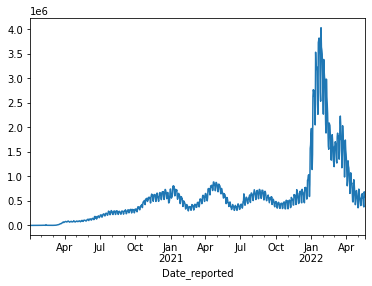

In [ ]:
covid1['Confirmed'].plot()

In [ ]:
import statsmodels.api as sm

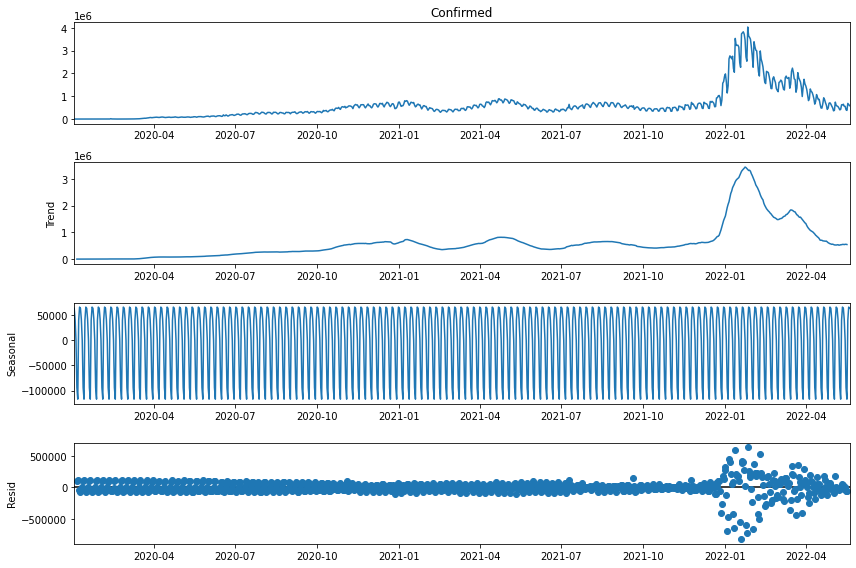

In [ ]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize']=12,8
decomposition = sm.tsa.seasonal_decompose(covid1.Confirmed, model='additive')
fig = decomposition.plot()
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
from typing import ValuesView
def adfuller_test(Confirmed):
  result = adfuller(Confirmed)
  labels = ['ADF Test statistic','p-value','#lags used','Number of observation used']
  for value, label in zip(result,labels):
    print(label+':'+str(value))
  if result[1] <= 0.05:
    print("strong evidence against the null hypothesis(ho), rejects the null vlaue . Data is stationary")
  else:
    print('Its is not stationary') 

In [ ]:
#adf_test(covid1['Confirmed'])
adfuller_test(covid1['Confirmed'])

ADF Test statistic:-2.428486261299856
p-value:0.13385723779056447
#lags used:21
Number of observation used:847
Its is not stationary


In [ ]:
covid1['confirmed First Difference']=covid1['Confirmed']-covid1['Confirmed'].shift(1)


In [ ]:
#adf_test(covid1['confirmed First Difference'].dropna())
adfuller_test(covid1['confirmed First Difference'].dropna())

ADF Test statistic:-6.4812681314702685
p-value:1.293257285348325e-08
#lags used:21
Number of observation used:846
strong evidence against the null hypothesis(ho), rejects the null vlaue . Data is stationary


In [ ]:
### 12 months 
## Use Techniques Differencing
covid1['Confirmed 12 Difference']=covid1['Confirmed']-covid1['Confirmed'].shift(12)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


In [ ]:
adfuller_test(covid1['Confirmed 12 Difference'].dropna())

ADF Test statistic:-7.035513542242078
p-value:6.030680072452386e-10
#lags used:21
Number of observation used:835
strong evidence against the null hypothesis(ho), rejects the null vlaue . Data is stationary


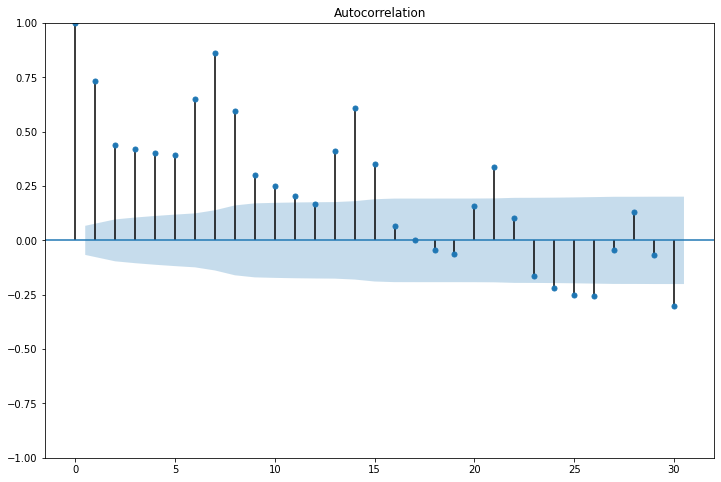

In [ ]:
acf12 = plot_acf(covid1["Confirmed 12 Difference"].dropna())

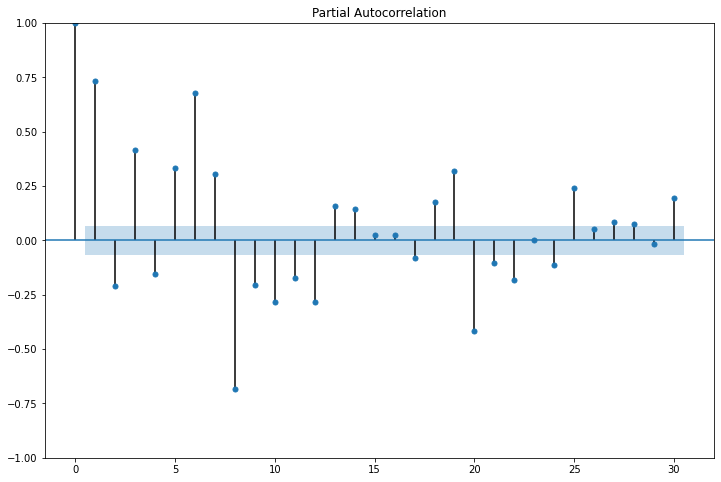

In [ ]:
pacf12 = plot_pacf(covid1["Confirmed 12 Difference"].dropna())

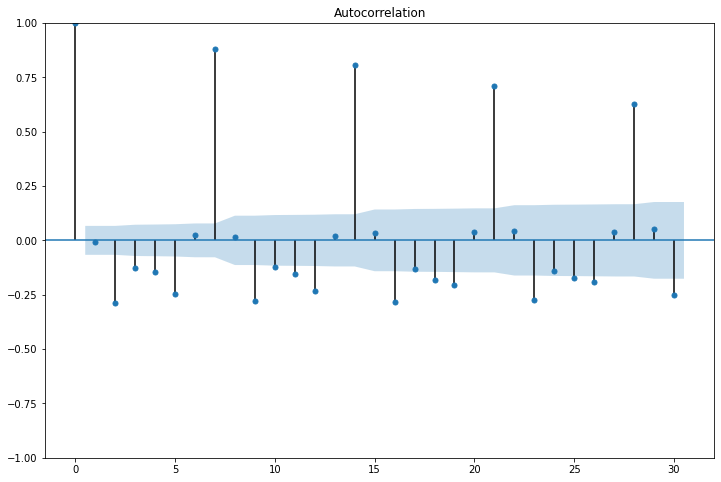

In [ ]:
acf = plot_acf(covid1["confirmed First Difference"].dropna())


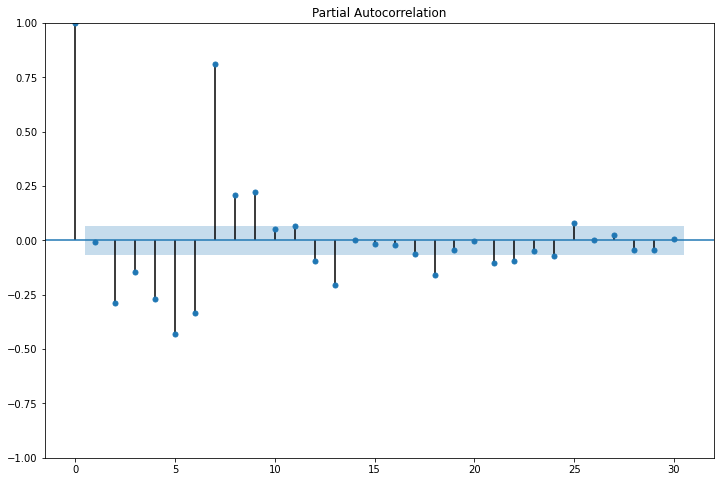

In [ ]:
result = plot_pacf(covid1["confirmed First Difference"].dropna())


In [ ]:
covid1

Confirmed  Deaths  confirmed First Difference  \
Date_reported                                                  
2020-01-03             0       0                         NaN   
2020-01-04             3       0                         3.0   
2020-01-05             0       0                        -3.0   
2020-01-06             3       0                         3.0   
2020-01-07             0       0                        -3.0   
...                  ...     ...                         ...   
2022-05-16        407801     872                   -150842.0   
2022-05-17        377553     990                    -30248.0   
2022-05-18        685584    1660                    308031.0   
2022-05-19        635861    1922                    -49723.0   
2022-05-20        587382    1298                    -48479.0   

               Confirmed 12 Difference  
Date_reported                           
2020-01-03                         NaN  
2020-01-04                         NaN  
2020-01-05                         NaN  
2020-01-06                         NaN  
2020-01-07                         NaN  
...                                ...  
2022-05-16                   -333910.0  
2022-05-17                   -217718.0  
2022-05-18                    115766.0  
2022-05-19                     89359.0  
2022-05-20                    103633.0  

[869 rows x 4 columns]

In [ ]:
from datetime import datetime,timedelta
train_dataset_end=datetime(2021,12,1)
test_dataset_end=datetime(2022,5,20)

In [ ]:
train_data=covid1[:train_dataset_end]
test_data=covid1[train_dataset_end+timedelta(days=1):test_dataset_end]

In [ ]:
##prediction
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]

In [ ]:
test_data

Confirmed  Deaths  confirmed First Difference  \
Date_reported                                                  
2021-12-02        687766    8393                     38903.0   
2021-12-03        698263    8151                     10497.0   
2021-12-04        686880    7616                    -11383.0   
2021-12-05        625738    9379                    -61142.0   
2021-12-06        473420    5662                   -152318.0   
...                  ...     ...                         ...   
2022-05-16        407801     872                   -150842.0   
2022-05-17        377553     990                    -30248.0   
2022-05-18        685584    1660                    308031.0   
2022-05-19        635861    1922                    -49723.0   
2022-05-20        587382    1298                    -48479.0   

               Confirmed 12 Difference  
Date_reported                           
2021-12-02                     70901.0  
2021-12-03                    153232.0  
2021-12-04                    260328.0  
2021-12-05                    173641.0  
2021-12-06                   -256395.0  
...                                ...  
2022-05-16                   -333910.0  
2022-05-17                   -217718.0  
2022-05-18                    115766.0  
2022-05-19                     89359.0  
2022-05-20                    103633.0  

[170 rows x 4 columns]

In [ ]:
## create a ARIMA model
#from statsmodels.tsa.arima_model import ARIMA

In [ ]:
#train_data

In [ ]:

#model_ARIMA=ARIMA(test_data['Confirmed'],order=(1,2,3))

In [ ]:
#model_Arima_fit=model_ARIMA.fit()

In [ ]:
#model_Arima_fit.summary()


In [ ]:
##prediction
#pred_start_date=test_data.index[0]
#pred_end_date=test_data.index[-1]
#print(pred_start_date)
#print(pred_end_date)

In [ ]:
#pred=model_Arima_fit.predict(start=datetime(2021,12,3),end=datetime(2022,5,20))
#residuals=test_data['Confirmed']-pred

In [ ]:
#pred_Sarima=model_SARIMA_fit.predict(start=datetime(2020,2,3),end=datetime(2021,12,1))

In [ ]:
#pd.to_datetime(covid1['index'],errors='ignore')

In [ ]:
#pred=model_Arima_fit.predict(start=pred_start_date,end=pred_end_date)
#residuals=test_data['Thousands of Passengers']-pred

In [ ]:
#pred

In [ ]:
#residuals

In [ ]:
#model_Arima_fit.resid.plot(kind='kde')

In [ ]:
#test_data['Predicted_Cases_ARIMA']=pred

In [ ]:
#test_data[['Confirmed','Predicted_Cases_ARIMA']].plot()

In [ ]:
#model_sarima= auto_arima(test_data["Confirmed"],trace=True, error_action='ignore', 
 #                        start_p=0,start_q=0,
  #                 suppress_warnings=True,stepwise=True,seasonal=True)
#model_arima.fit(test_data["Confirmed"])

In [ ]:
#acf12 = plot_acf(covid1["Confirmed 12 Difference"].dropna())

In [ ]:
#pacf12 = plot_pacf(covid1["Confirmed 12 Difference"].dropna())

In [ ]:
### create a SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
train_data.index = pd.DatetimeIndex(train_data.index.values,
                               freq=train_data.index.inferred_freq)

In [ ]:
test_data.index = pd.DatetimeIndex(test_data.index.values,
                               freq=test_data.index.inferred_freq)

In [ ]:
covid1.index = pd.DatetimeIndex(covid1.index.values,
                               freq=covid1.index.inferred_freq)

In [ ]:
model_SARIMA=SARIMAX(train_data['Confirmed'],order=(5,0,5),seasonal_order=(0,1,0,12))


In [ ]:
modell_SARIMA_fit=model_SARIMA.fit(maxiter=200)

In [ ]:
modell_SARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           Confirmed   No. Observations:                  699
Model:             SARIMAX(5, 0, 5)x(0, 1, [], 12)   Log Likelihood               -8153.730
Date:                             Sat, 28 May 2022   AIC                          16329.461
Time:                                     14:42:43   BIC                          16379.317
Sample:                                 01-03-2020   HQIC                         16348.750
                                      - 12-01-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7577      0.023     77.634      0.000       1.713       1.802
ar.L2         -2.2049      0.028    -79.371      0.000      -2.259      -2.150
ar.L3          2.1798      0.038     57.532      0.000       2.106       2.254
ar.L4         -1.7606      0.026    -69.027      0.000      -1.811      -1.711
ar.L5          0.9622      0.019     49.927      0.000       0.924       1.000
ma.L1         -1.0618      0.049    -21.493      0.000      -1.159      -0.965
ma.L2          1.5227      0.058     26.119      0.000       1.408       1.637
ma.L3         -1.0395      0.081    -12.787      0.000      -1.199      -0.880
ma.L4          0.9356      0.060     15.600      0.000       0.818       1.053
ma.L5         -0.3370      0.048     -7.044      0.000      -0.431      -0.243
sigma2      1.879e+09   1.43e-11   1.32e+20      0.000    1.88e+09    1.88e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              1296.70
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):              17.64   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.34e+36. Standard errors may be unstable.
"""

In [ ]:
##prediction
pred_start_date=train_data.index[0]
pred_end_date=train_data.index[-1]
print(pred_start_date)
print(pred_end_date)

2020-01-03 00:00:00
2021-12-01 00:00:00


In [ ]:
pred_Sarima=modell_SARIMA_fit.predict(start=datetime(2020,1,3),end=datetime(2021,12,1))
residuals=train_data['Confirmed']-pred_Sarima

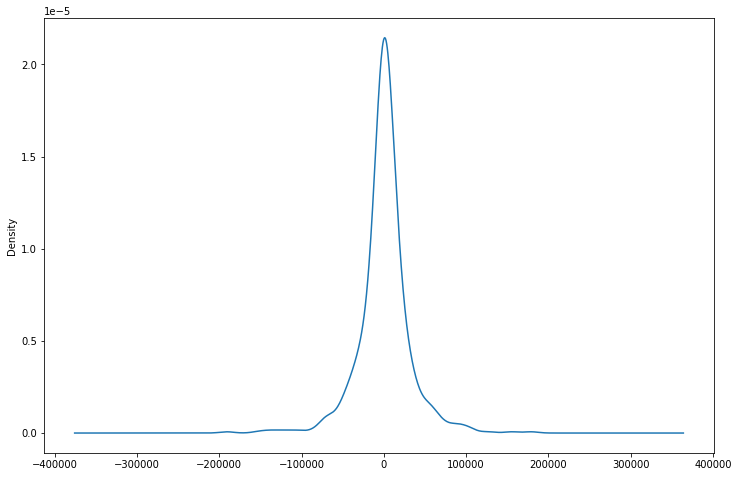

In [ ]:
modell_SARIMA_fit.resid.plot(kind='kde')

In [ ]:
train_data['Predicted_SARIMA']=pred_Sarima

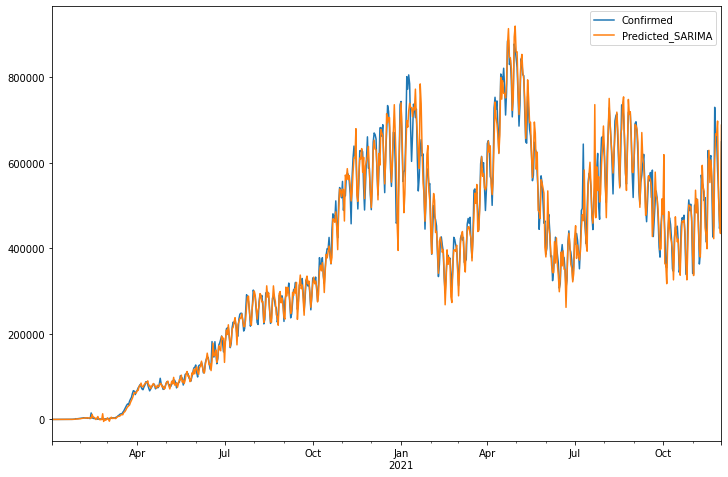

In [ ]:
train_data[['Confirmed','Predicted_SARIMA']].plot()


In [ ]:
new_date=[]
#new_prediction_lr=[]
#new_prediction_svm=[]
for i in range(1,18):
    new_date.append(train_data.index[-1]+timedelta(days=i))

In [ ]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(new_date),
                              columns=["Dates"])
model_predictions.head()

Dates
0 2021-12-02
1 2021-12-03
2 2021-12-04
3 2021-12-05
4 2021-12-06

In [ ]:
AR_model_new_prediction=[]
#model_predictions = []
for i in range(1,18):
    AR_model_new_prediction.append(modell_SARIMA_fit.predict(len(train_data)+i)[-1])
model_predictions["AR Model Prediction"]=AR_model_new_prediction
#model_predictions["Actual Confirmed"]=model_train['Confirmed']
model_predictions

Dates  AR Model Prediction
0  2021-12-02        635855.589535
1  2021-12-03        618023.142256
2  2021-12-04        533309.539333
3  2021-12-05        545152.964684
4  2021-12-06        487286.207698
5  2021-12-07        711206.964387
6  2021-12-08        664383.234660
7  2021-12-09        619109.726059
8  2021-12-10        631554.433535
9  2021-12-11        540703.777748
10 2021-12-12        457667.715575
11 2021-12-13        539511.252203
12 2021-12-14        682939.241165
13 2021-12-15        698053.294585
14 2021-12-16        617668.300639
15 2021-12-17        724911.815821
16 2021-12-18        550696.514271

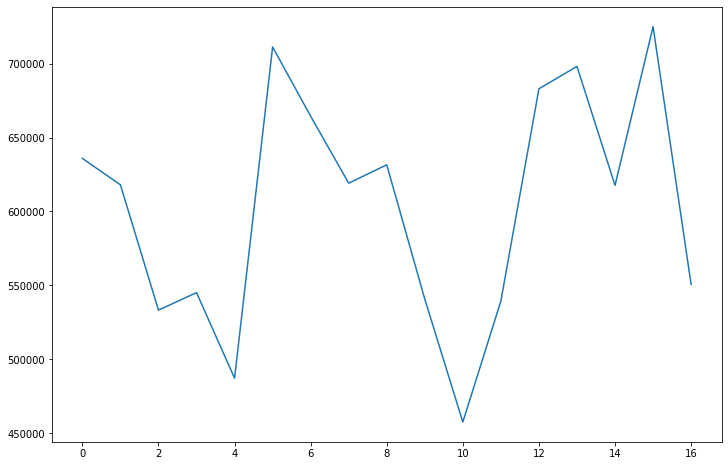

In [ ]:
model_predictions['AR Model Prediction'].plot()

In [ ]:
model_sarima= auto_arima(test_data["Confirmed"],trace=True, error_action='ignore', 
                         start_p=0,start_q=0,
                   suppress_warnings=True,stepwise=True,seasonal=True)
model_sarima.fit(test_data["Confirmed"])

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4793.123, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4795.042, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4794.954, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4791.126, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4783.164, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4770.111, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4782.705, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4770.887, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4765.292, Time=0.67 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4765.635, Time=0.46 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4763.600, Time=0.57 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4755.090, Time=0.97 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4760.883, Time=0.30 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=4686.698, Time=1.28 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept

ARIMA(order=(5, 1, 5), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
model_SARIMA=SARIMAX(test_data['Confirmed'],order=(5,0,5),seasonal_order=(0,1,0,12))
modell_SARIMA_fit=model_SARIMA.fit(maxiter=200)
modell_SARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           Confirmed   No. Observations:                  170
Model:             SARIMAX(5, 0, 5)x(0, 1, [], 12)   Log Likelihood               -2214.852
Date:                             Sat, 28 May 2022   AIC                           4451.704
Time:                                     14:43:03   BIC                           4485.393
Sample:                                 12-02-2021   HQIC                          4465.386
                                      - 05-20-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8083      0.100     18.135      0.000       1.613       2.004
ar.L2         -2.2407      0.156    -14.390      0.000      -2.546      -1.936
ar.L3          2.1953      0.153     14.317      0.000       1.895       2.496
ar.L4         -1.7299      0.127    -13.670      0.000      -1.978      -1.482
ar.L5          0.9204      0.072     12.756      0.000       0.779       1.062
ma.L1         -1.2385      0.293     -4.234      0.000      -1.812      -0.665
ma.L2          1.5590      0.437      3.569      0.000       0.703       2.415
ma.L3         -1.0905      0.517     -2.108      0.035      -2.105      -0.076
ma.L4          0.6223      0.395      1.575      0.115      -0.152       1.397
ma.L5          0.0919      0.244      0.376      0.707      -0.387       0.571
sigma2      1.676e+11   5.36e-13   3.13e+23      0.000    1.68e+11    1.68e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 1.59
Prob(Q):                              0.81   Prob(JB):                         0.45
Heteroskedasticity (H):               0.11   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.21e+42. Standard errors may be unstable.
"""

In [ ]:
##prediction
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]
print(pred_start_date)
print(pred_end_date)

2021-12-02 00:00:00
2022-05-20 00:00:00


In [ ]:
pred_Sarima = modell_SARIMA_fit.predict(start=datetime(2021,12,3),end=datetime(2022,5,21))
residuals=test_data['Confirmed']-pred_Sarima

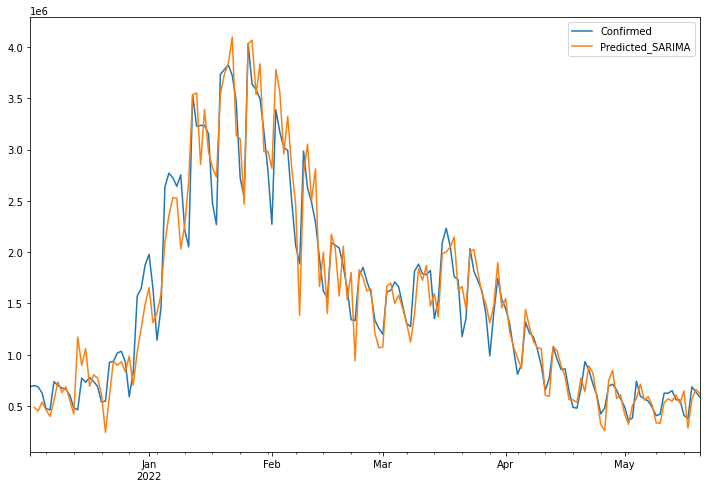

In [ ]:
test_data['Predicted_SARIMA']=pred_Sarima
test_data[['Confirmed','Predicted_SARIMA']].plot()

In [ ]:
new_date=[]
#new_prediction_lr=[]
#new_prediction_svm=[]
for i in range(1,18):
    new_date.append(covid1.index[-1]+timedelta(days=i))

In [ ]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
Case_predictions=pd.DataFrame(zip(new_date),
                              columns=["Dates"])
Case_predictions.head()

Dates
0 2022-05-21
1 2022-05-22
2 2022-05-23
3 2022-05-24
4 2022-05-25

In [ ]:
new_predicted=[]
#model_predictions = []
for i in range(1,18):
    new_predicted.append(modell_SARIMA_fit.predict(len(test_data)+i)[-1])
Case_predictions["AR Model Prediction"]=new_predicted
#model_predictions["Actual Confirmed"]=model_train['Confirmed']
Case_predictions

Dates  AR Model Prediction
0  2022-05-21        434868.672878
1  2022-05-22        376882.435508
2  2022-05-23        498075.804376
3  2022-05-24        727204.990779
4  2022-05-25        612346.246531
5  2022-05-26        645133.749793
6  2022-05-27        607188.633502
7  2022-05-28        408576.927781
8  2022-05-29        466094.568276
9  2022-05-30        505656.609713
10 2022-05-31        646546.693393
11 2022-06-01        668121.971794
12 2022-06-02        509233.918593
13 2022-06-03        559718.062664
14 2022-06-04        542480.991289
15 2022-06-05        534666.317143
16 2022-06-06        480445.179668

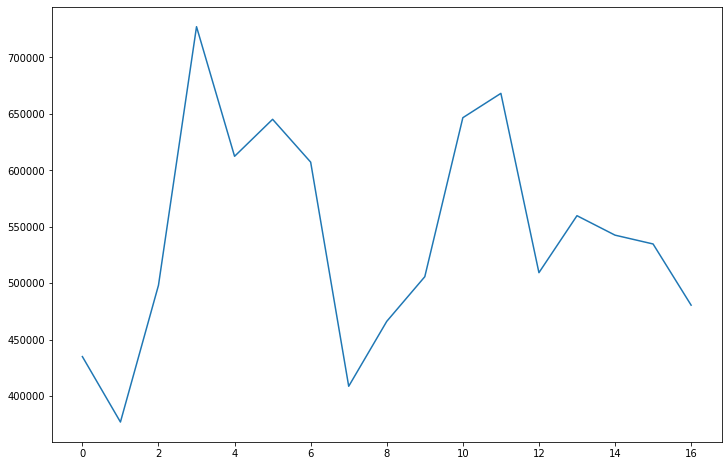

In [ ]:
Case_predictions['AR Model Prediction'].plot()

**For Death Cases**

In [ ]:
covid1

Confirmed  Deaths  confirmed First Difference  \
2020-01-03          0       0                         NaN   
2020-01-04          3       0                    3.000000   
2020-01-05          0       0                   -3.000000   
2020-01-06          3       0                    3.000000   
2020-01-07          0       0                   -3.000000   
...               ...     ...                         ...   
2022-05-16     407801     872              -150842.000000   
2022-05-17     377553     990               -30248.000000   
2022-05-18     685584    1660               308031.000000   
2022-05-19     635861    1922               -49723.000000   
2022-05-20     587382    1298               -48479.000000   

            Confirmed 12 Difference  
2020-01-03                      NaN  
2020-01-04                      NaN  
2020-01-05                      NaN  
2020-01-06                      NaN  
2020-01-07                      NaN  
...                             ...  
2022-05-16           -333910.000000  
2022-05-17           -217718.000000  
2022-05-18            115766.000000  
2022-05-19             89359.000000  
2022-05-20            103633.000000  

[869 rows x 4 columns]

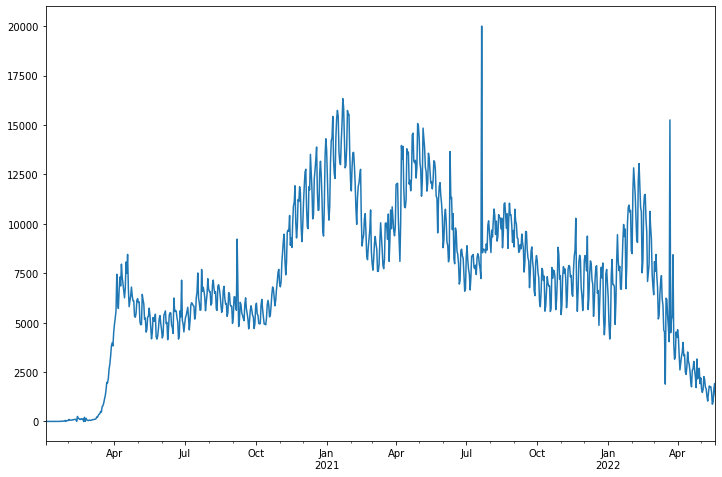

In [ ]:
covid1['Deaths'].plot()

Augmented Dickey-Fuller (ADF) test

In [ ]:
from typing import ValuesView
def adfull_test(Deaths):
  result = adfuller(Deaths)
  labels = ['ADF Test statistic','p-value','#lags used','Number of observation used']
  for value, label in zip(result,labels):
    print(label+':'+str(value))
  if result[1] <= 0.05:
    print("strong evidence against the null hypothesis(ho), rejects the null vlaue . Data is stationary")
  else:
    print('Its is not stationary') 

#adf_test(covid1['Confirmed'])
adfull_test(covid1['Deaths'])

ADF Test statistic:-2.670682355580747
p-value:0.07925034388792324
#lags used:17
Number of observation used:851
Its is not stationary


In [ ]:
### 12 months 
## Use Techniques Differencing
covid1['Deaths 12 Difference']=covid1['Deaths']-covid1['Deaths'].shift(12)

In [ ]:
adfull_test(covid1['Deaths 12 Difference'].dropna())

ADF Test statistic:-4.43036242010174
p-value:0.0002621832704330658
#lags used:21
Number of observation used:835
strong evidence against the null hypothesis(ho), rejects the null vlaue . Data is stationary


In [ ]:
model_sarima= auto_arima(test_data["Deaths"],trace=True, error_action='ignore', 
                         start_p=0,start_q=0,
                   suppress_warnings=True,stepwise=True,seasonal=True)
#model_sarima.fit(test_data["Deaths"])

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2999.863, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2987.813, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2965.667, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2997.968, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2958.000, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2957.548, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2985.100, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2949.720, Time=0.30 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2969.574, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2949.815, Time=0.37 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2938.481, Time=0.67 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2937.793, Time=0.63 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2

In [ ]:
model_SARIMA=SARIMAX(test_data['Deaths'],order=(5,0,5),seasonal_order=(0,1,0,12))
model_SARIMA_fit=model_SARIMA.fit(maxiter=200)
model_SARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                              Deaths   No. Observations:                  170
Model:             SARIMAX(5, 0, 5)x(0, 1, [], 12)   Log Likelihood               -1412.966
Date:                             Sat, 28 May 2022   AIC                           2847.932
Time:                                     14:43:23   BIC                           2881.620
Sample:                                 12-02-2021   HQIC                          2861.613
                                      - 05-20-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4553      0.131      3.471      0.001       0.198       0.712
ar.L2          0.5406      0.118      4.582      0.000       0.309       0.772
ar.L3         -0.7667      0.103     -7.419      0.000      -0.969      -0.564
ar.L4         -0.3071      0.148     -2.078      0.038      -0.597      -0.017
ar.L5          0.7009      0.109      6.424      0.000       0.487       0.915
ma.L1         -0.1173      0.204     -0.575      0.565      -0.517       0.282
ma.L2         -0.4582      0.155     -2.954      0.003      -0.762      -0.154
ma.L3          0.5726      0.132      4.331      0.000       0.313       0.832
ma.L4          0.5653      0.173      3.264      0.001       0.226       0.905
ma.L5         -0.6657      0.177     -3.768      0.000      -1.012      -0.319
sigma2      4.247e+06    1.3e-07   3.27e+13      0.000    4.25e+06    4.25e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):              1449.75
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                             0.52
Prob(H) (two-sided):                  0.44   Kurtosis:                        17.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.37e+28. Standard errors may be unstable.
"""

In [ ]:
import pickle
pickle.dump(model_SARIMA_fit, open("model.pkl",'wb'))

In [ ]:
pickle.dump(modell_SARIMA_fit, open("confirmed_model.pkl",'wb'))

In [ ]:
pred_Sarima_deaths = model_SARIMA_fit.predict(start=datetime(2021,12,3),end=datetime(2022,5,21))
residuals=test_data['Deaths']-pred_Sarima_deaths

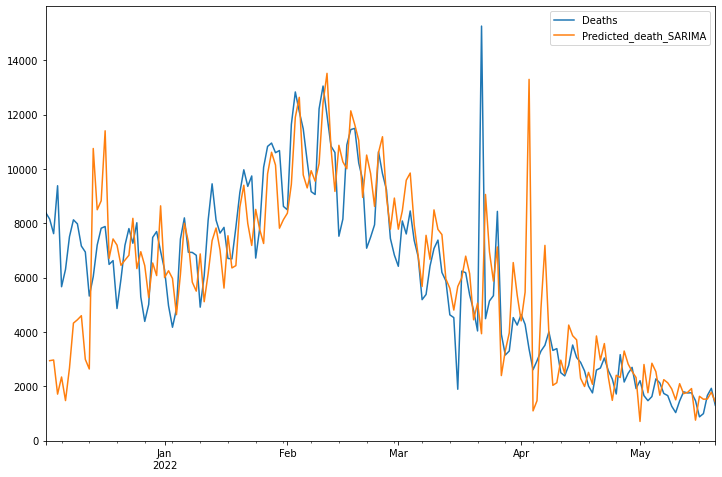

In [ ]:
test_data['Predicted_death_SARIMA']=pred_Sarima_deaths
test_data[['Deaths','Predicted_death_SARIMA']].plot()

In [ ]:
model_SARIMA=SARIMAX(train_data['Deaths'],order=(5,0,5),seasonal_order=(0,1,0,12))
model_SARIMA_fit=model_SARIMA.fit(maxiter=200)
model_SARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                              Deaths   No. Observations:                  699
Model:             SARIMAX(5, 0, 5)x(0, 1, [], 12)   Log Likelihood               -5784.160
Date:                             Sat, 28 May 2022   AIC                          11590.320
Time:                                     14:43:47   BIC                          11640.175
Sample:                                 01-03-2020   HQIC                         11609.608
                                      - 12-01-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6528      0.030     21.960      0.000       0.595       0.711
ar.L2          0.4309      0.036     12.081      0.000       0.361       0.501
ar.L3         -0.6781      0.033    -20.710      0.000      -0.742      -0.614
ar.L4         -0.2632      0.035     -7.578      0.000      -0.331      -0.195
ar.L5          0.7650      0.022     35.155      0.000       0.722       0.808
ma.L1         -0.1731      0.060     -2.876      0.004      -0.291      -0.055
ma.L2         -0.5030      0.039    -12.909      0.000      -0.579      -0.427
ma.L3          0.4990      0.032     15.396      0.000       0.435       0.563
ma.L4          0.5631      0.071      7.909      0.000       0.424       0.703
ma.L5         -0.7105      0.040    -17.717      0.000      -0.789      -0.632
sigma2      1.284e+06   6.95e+04     18.479      0.000    1.15e+06    1.42e+06
===================================================================================
Ljung-Box (L1) (Q):                   5.95   Jarque-Bera (JB):             31800.10
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               6.35   Skew:                             1.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pred_Sarima_death=model_SARIMA_fit.predict(start=datetime(2020,1,3),end=datetime(2021,12,1))
residuals=train_data['Deaths']-pred_Sarima_death

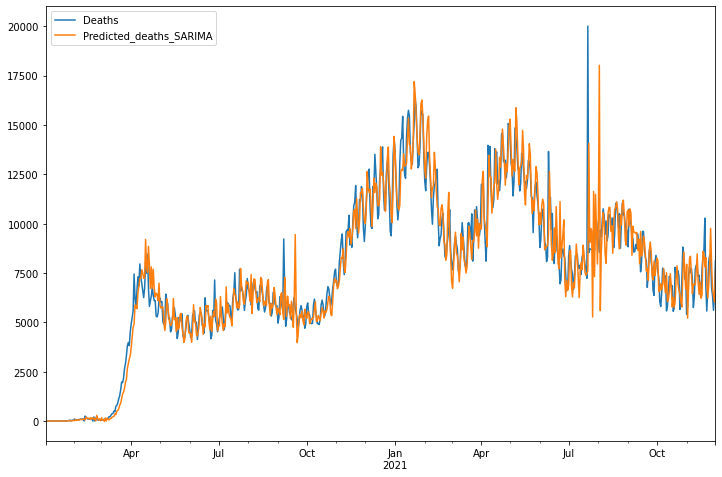

In [ ]:
train_data['Predicted_deaths_SARIMA']=pred_Sarima_death
train_data[['Deaths','Predicted_deaths_SARIMA']].plot()

In [ ]:
deaths_prediction=[]
#model_predictions = []
for i in range(1,18):
    deaths_prediction.append(model_SARIMA_fit.predict(len(train_data)+i)[-1])
model_predictions["Deaths Cases Predicted"]=deaths_prediction
#model_predictions["Actual Confirmed"]=model_train['Confirmed']
model_predictions

Dates  AR Model Prediction  Deaths Cases Predicted
0  2021-12-02        635855.589535             8537.569651
1  2021-12-03        618023.142256             7149.144869
2  2021-12-04        533309.539333             6766.502908
3  2021-12-05        545152.964684             6851.329981
4  2021-12-06        487286.207698             6452.243353
5  2021-12-07        711206.964387             7164.815706
6  2021-12-08        664383.234660             7236.120171
7  2021-12-09        619109.726059             7968.430748
8  2021-12-10        631554.433535             7158.027297
9  2021-12-11        540703.777748             6578.403459
10 2021-12-12        457667.715575             6871.846981
11 2021-12-13        539511.252203             8820.218109
12 2021-12-14        682939.241165             7518.767715
13 2021-12-15        698053.294585             7678.549137
14 2021-12-16        617668.300639             8378.189425
15 2021-12-17        724911.815821             8351.110607
16 2021-12-18        550696.514271             6616.131704

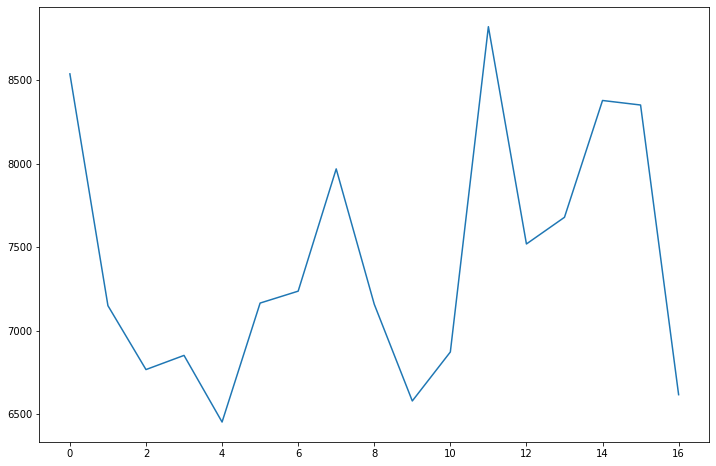

In [ ]:
model_predictions['Deaths Cases Predicted'].plot()

In [ ]:
test_data[["Confirmed","Deaths"]]

Confirmed  Deaths
2021-12-02     687766    8393
2021-12-03     698263    8151
2021-12-04     686880    7616
2021-12-05     625738    9379
2021-12-06     473420    5662
...               ...     ...
2022-05-16     407801     872
2022-05-17     377553     990
2022-05-18     685584    1660
2022-05-19     635861    1922
2022-05-20     587382    1298

[170 rows x 2 columns]

In [ ]:
# import numpy as np
# y = np.array([2022-5-20])
# mp = y.reshape(-1, 1)
# prediction = model_SARIMA_fit.predict(mp)
y = 2022-5-19
#y.resample(D)
predict = model_SARIMA_fit.predict(y)
#pred = pd.DataFrame(predict)
#pred.rename(columns = {'0':'pred'})
#covid.rename(columns = {'New_cases':'Confirmed', 'New_deaths':'Deaths'}, inplace = True)
#YArray= predict.as_matrix()
#YArray.astype(‘float’).reshape(-1, 2)
#print(YArray)
print(predict.item()) 
#pred.value[0]

7252.588986160864


In [ ]:
#type(predict)